In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import config
import process_data

In [2]:
# define ivim function
def ivim(b, Dp, Dt, Fp):
    return Fp*np.exp(-b*Dp) + (1-Fp)*np.exp(-b*Dt)

# apply mask: only keep vox with mask = 1

**Single subject Data 100206**

In [3]:
scan = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [4]:
mask = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [5]:
scan_dimension = scan.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [6]:
print(x, y, z, b)

print('The shape of scan: ')
print(scan.shape)
print('The shape of mask: ')
print(mask.shape)

print(type(scan), type(mask))

145 174 145 288
The shape of scan: 
(145, 174, 145, 288)
The shape of mask: 
(145, 174, 145)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
scan_long = np.reshape(scan, (x*y*z, b))

In [8]:
mask_long = np.reshape(mask, (x*y*z, 1))

In [15]:
scan_long_no_background = process_data.trim_background(scan_long, mask_long)

In [16]:
scan_long_no_background.shape

(936256, 288)

In [18]:
scan_long_no_bg_cp = scan_long_no_background

In [19]:
# Ignore all strange data

def find_rows_beginning_with_zero(scan_long_no_bg):
    return np.where(scan_long_no_bg[:, 0] == 0)[0]

Sb_beginning_0 = find_rows_beginning_with_zero(scan_long_no_background)
scan_long_no_bg = np.delete(scan_long_no_background, Sb_beginning_0, 0)

print(scan_long_no_bg.shape)
print(scan_long_no_background.shape)

(935442, 288)
(936256, 288)


In [ ]:
# Ignore data that leads to S0 in [0, 1)

# bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')
# S0 = process_data.get_S0(scan_long_no_background, bval_list)
# error_voxels = np.argwhere(np.logical_and(S0 >= 0, S0 < 1))[:,0]
# scan_long_no_bg = np.delete(scan_long_no_background, error_voxels, 0)
# S0_ = np.delete(S0, error_voxels, 0)
# np.save('S0_2.npy',S0_)

In [20]:
bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [21]:
S0 = process_data.get_S0(scan_long_no_bg, bval_list)
# S0 = np.load('S0_1.npy')

In [22]:
S0.shape

(935442, 1)

In [24]:
normalized_scan_long_no_background = process_data.normalize_scan(scan_long_no_bg, S0)

In [34]:
# np.save('normalized_scan_long_2.npy', normalized_scan_long_no_background)
normalized_scan_long_no_background = np.load('normalized_scan_long_1.npy')

In [32]:
# normalized_scan_long_no_background.shape
Ab_voxels = np.argwhere(np.logical_and(S0 >= 0, S0 < 1))[:,0]
print(Ab_voxels)

[229768 536137 850262]


In [33]:
scan_long_no_bg

array([[587.17718506, 358.32980347, 231.72703552, ..., 299.55273438,
        255.15158081, 142.32798767],
       [507.74441528, 209.08628845, 260.41522217, ..., 203.17358398,
        306.38717651, 163.31565857],
       [487.08456421, 222.9410553 , 164.82409668, ..., 173.70411682,
        261.70492554, 141.86515808],
       ...,
       [812.58972168, 293.08770752, 151.81272888, ..., 234.93511963,
        148.44284058, 252.454422  ],
       [611.19360352, 356.01541138, 282.81274414, ..., 197.86349487,
        240.8157196 , 113.83872986],
       [881.83642578, 131.84002686, 136.59486389, ..., 252.69070435,
        327.61587524, 269.12463379]])

In [35]:
print(normalized_scan_long_no_background.shape)
print(S0.shape)

(935439, 288)
(935442, 1)


In [36]:
np.argwhere(normalized_scan_long_no_background>10)

array([[117489,      4],
       [117489,     20],
       [117489,     60],
       ...,
       [784703,    214],
       [784703,    231],
       [838711,     90]])

In [37]:
np.unique(bval_list)

array([   5.,  990.,  995., 1000., 1005., 1985., 1990., 1995., 2000.,
       2005., 2010., 2980., 2985., 2990., 2995., 3000., 3005., 3010.])

## Neural Network Training

Let's create the neural network class and instantiate it.

In [38]:
class Net(nn.Module):
    def __init__(self, b_values_no0):
        super(Net, self).__init__()

        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), 3))

    def forward(self, X):
        # print('x')
        # print(X.shape)
        params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
        # print(params.shape)
        # print(params)
        Dp = params[:, 0].unsqueeze(1)
        Dt = params[:, 1].unsqueeze(1)
        Fp = params[:, 2].unsqueeze(1)

        X = Fp*torch.exp(-self.b_values_no0*Dp) + (1-Fp)*torch.exp(-self.b_values_no0*Dt)

        return X, Dp, Dt, Fp

In [39]:
net = Net(bval_list)
print(net)

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=3, bias=True)
  )
)


In [40]:
# Network
b_values = torch.FloatTensor(bval_list)
net = Net(b_values)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)  

Create batch queues.

In [41]:
batch_size = 128
num_batches = len(normalized_scan_long_no_background) // batch_size
# X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)

In [14]:
net2 = Net(b_values)

Train, this might take a few minutes.

In [ ]:
# epoch, lr, layer, data size increase

In [42]:
loss_arr=[]

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10000

# Train
counter = 0
for epoch in range(200): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # print('Running_loss: ', running_loss)
        # print('X_batch: ')
        # print(X_batch.shape)
        # print(X_batch)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        # print('X_pred: ')
        # print(X_pred.shape)
        # print(X_pred)
        if i == 8 and counter == 10:
            print('X_batch: ')
            print(X_batch)
            print('X_pred: ')
            print(X_pred)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        # print('loss: ', loss.item())
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/len(trainloader)))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.81it/s]


Loss: 1193.2649480327964
Average Loss: 0.16328201259343136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.46it/s]


Loss: 1172.8881651870906
Average Loss: 0.1604937281317858
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.74it/s]


Loss: 1201.6287262812257
Average Loss: 0.16442648142873914
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.00it/s]


Loss: 1209.3360666707158
Average Loss: 0.16548112570754184
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.97it/s]


Loss: 1201.9571572840214
Average Loss: 0.16447142272633022
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.17it/s]


Loss: 1186.7908086702228
Average Loss: 0.16239611503423956
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.31it/s]


Loss: 903.6337441317737
Average Loss: 0.12364993762065869
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.92it/s]


Loss: 614.9046060154215
Average Loss: 0.08414129803166687
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.24it/s]


Loss: 595.9763317089528
Average Loss: 0.08155122218239638
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.62it/s]


Loss: 574.7929630698636
Average Loss: 0.07865256746987734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  1%|▋                                                                                                       | 47/7308 [00:01<02:52, 42.05it/s]

X_batch: 
tensor([[0.9098, 0.5582, 0.0825,  ..., 0.4178, 0.2279, 0.1201],
        [0.9327, 0.4758, 0.1974,  ..., 0.3556, 0.2014, 0.1460],
        [0.9704, 0.4720, 0.1829,  ..., 0.4410, 0.2814, 0.1049],
        ...,
        [1.0134, 0.0908, 0.0255,  ..., 0.1061, 0.0394, 0.0325],
        [1.0146, 0.6289, 0.1865,  ..., 0.5799, 0.2990, 0.2519],
        [0.9972, 0.4246, 0.2612,  ..., 0.3008, 0.1402, 0.1559]])
X_pred: 
tensor([[0.9655, 0.4382, 0.3966,  ..., 0.4380, 0.3966, 0.3587],
        [0.9508, 0.3872, 0.3568,  ..., 0.3871, 0.3568, 0.3286],
        [0.9546, 0.3749, 0.3167,  ..., 0.3746, 0.3167, 0.2671],
        ...,
        [0.9414, 0.1602, 0.1561,  ..., 0.1602, 0.1561, 0.1521],
        [0.9642, 0.4351, 0.3758,  ..., 0.4348, 0.3758, 0.3242],
        [0.9608, 0.3747, 0.3097,  ..., 0.3744, 0.3097, 0.2555]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.52it/s]


Loss: 572.7051802501082
Average Loss: 0.07836688290231367
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.56it/s]


Loss: 572.8322649849579
Average Loss: 0.07838427271277475
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.59it/s]


Loss: 558.2861306364648
Average Loss: 0.07639383287307948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.75it/s]


Loss: 555.4235386801884
Average Loss: 0.07600212625618341
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.81it/s]


Loss: 564.054906305857
Average Loss: 0.07718321104349439
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.01it/s]


Loss: 576.015451923944
Average Loss: 0.07881984837492392
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.23it/s]


Loss: 569.7010128712282
Average Loss: 0.07795580362222608
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.37it/s]


Loss: 573.1566237327643
Average Loss: 0.07842865677788236
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.46it/s]


Loss: 555.260851349216
Average Loss: 0.07597986471664148
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.69it/s]


Loss: 556.7416855320334
Average Loss: 0.07618249665189292
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.93it/s]


Loss: 563.2266744975932
Average Loss: 0.07706987883108829
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.49it/s]


Loss: 518.1573104336858
Average Loss: 0.07090275183821644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.41it/s]


Loss: 534.9394859527238
Average Loss: 0.07319916337612531
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.13it/s]


Loss: 545.3260317388922
Average Loss: 0.07462042032551891
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.35it/s]


Loss: 533.541402824223
Average Loss: 0.07300785479258662
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.41it/s]


Loss: 553.2208761856891
Average Loss: 0.07570072197395855
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.58it/s]


Loss: 535.2412074087188
Average Loss: 0.07324044983698944
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.28it/s]


Loss: 521.1710512111895
Average Loss: 0.07131514110716879
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.79it/s]


Loss: 512.898113865871
Average Loss: 0.07018310260890408
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.86it/s]


Loss: 493.5388599107973
Average Loss: 0.0675340530802952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.07it/s]


Loss: 539.6105636795983
Average Loss: 0.07383833657356298
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.73it/s]


Loss: 536.2915675598197
Average Loss: 0.07338417727966881
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.03it/s]


Loss: 515.7549129612744
Average Loss: 0.07057401655189852
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.31it/s]


Loss: 611.8573769242503
Average Loss: 0.08372432634431448
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.33it/s]


Loss: 554.0352058960125
Average Loss: 0.07581215187411228
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.65it/s]


Loss: 520.5672809006646
Average Loss: 0.07123252338542209
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.61it/s]


Loss: 519.0413473970257
Average Loss: 0.0710237202240046
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.59it/s]


Loss: 521.1851183571853
Average Loss: 0.07131706600399361
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.82it/s]


Loss: 553.0546593586914
Average Loss: 0.0756779774710853
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.03it/s]


Loss: 511.6386664127931
Average Loss: 0.0700107644243012
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.58it/s]


Loss: 528.8823325838894
Average Loss: 0.07237032465570462
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.25it/s]


Loss: 515.0325971008278
Average Loss: 0.07047517749053474
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.87it/s]


Loss: 523.4408110217191
Average Loss: 0.07162572674079354
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.01it/s]


Loss: 507.71281575690955
Average Loss: 0.06947356537450869
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.67it/s]


Loss: 513.8010503565893
Average Loss: 0.07030665713691697
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.33it/s]


Loss: 520.1024050149135
Average Loss: 0.07116891146892632
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.96it/s]


Loss: 501.55991781177
Average Loss: 0.06863162531633415
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.79it/s]


Loss: 504.9168025054969
Average Loss: 0.06909096914415666
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.15it/s]


Loss: 514.6778193004429
Average Loss: 0.07042663099349246
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.38it/s]


Loss: 507.54237784212455
Average Loss: 0.06945024327341606
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.63it/s]


Loss: 520.4695142060518
Average Loss: 0.07121914534839242
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.91it/s]


Loss: 516.2404334656894
Average Loss: 0.07064045340253003
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.52it/s]


Loss: 506.04295900277793
Average Loss: 0.06924506828171564
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.69it/s]


Loss: 506.09556446177885
Average Loss: 0.06925226662038572
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.55it/s]


Loss: 532.7125496077351
Average Loss: 0.07289443754895117
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.18it/s]


Loss: 502.34149395208806
Average Loss: 0.06873857333772415
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.98it/s]


Loss: 504.1539492094889
Average Loss: 0.06898658308832635
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.43it/s]


Loss: 499.89790428616107
Average Loss: 0.0684042014622552
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.15it/s]


Loss: 494.4896603585221
Average Loss: 0.06766415713718146
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.38it/s]


Loss: 503.39223337732255
Average Loss: 0.06888235267888924
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.10it/s]


Loss: 493.24293939303607
Average Loss: 0.06749356039860921
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.02it/s]


Loss: 513.8616590187885
Average Loss: 0.07031495060465086
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.40it/s]


Loss: 499.8112020958215
Average Loss: 0.06839233745153551
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.69it/s]


Loss: 497.26805991865695
Average Loss: 0.0680443431744194
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.94it/s]


Loss: 501.3556463238783
Average Loss: 0.06860367355280218
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.39it/s]


Loss: 484.1445127087645
Average Loss: 0.06624856495741167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.63it/s]


Loss: 488.27974768169224
Average Loss: 0.0668144153915835
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.92it/s]


Loss: 520.3802129221149
Average Loss: 0.07120692568720784
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.68it/s]


Loss: 489.3432057653554
Average Loss: 0.06695993510746516
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.09it/s]


Loss: 495.41730834916234
Average Loss: 0.06779109309649184
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.96it/s]


Loss: 487.28150446200743
Average Loss: 0.06667781943924568
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.57it/s]


Loss: 489.22514432435855
Average Loss: 0.06694378001154332
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.68it/s]


Loss: 488.68052089074627
Average Loss: 0.06686925573217656
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.77it/s]


Loss: 490.4234781349078
Average Loss: 0.06710775562875038
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.57it/s]


Loss: 492.05045832600445
Average Loss: 0.0673303856494259
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.60it/s]


Loss: 495.36413205368444
Average Loss: 0.06778381664664539
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.78it/s]


Loss: 519.2703588521108
Average Loss: 0.07105505731419141
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.67it/s]


Loss: 496.5573537047021
Average Loss: 0.06794709273463356
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.45it/s]


Loss: 499.46114053437486
Average Loss: 0.06834443630738572
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.34it/s]


Loss: 494.4410368548706
Average Loss: 0.06765750367472231
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.26it/s]


Loss: 493.71753477631137
Average Loss: 0.06755850229560911
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.32it/s]


Loss: 479.64811536390334
Average Loss: 0.06563329438477057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.87it/s]


Loss: 497.34960652841255
Average Loss: 0.06805550171434217
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.55it/s]


Loss: 493.54586860584095
Average Loss: 0.0675350121244993
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.14it/s]


Loss: 500.14719396457076
Average Loss: 0.06843831335037914
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.48it/s]


Loss: 483.5739883854985
Average Loss: 0.06617049649500527
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.43it/s]


Loss: 488.8736103400588
Average Loss: 0.06689567738643389
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.32it/s]


Loss: 482.66171971708536
Average Loss: 0.06604566498591753
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.52it/s]


Loss: 509.8094662860967
Average Loss: 0.06976046336700831
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.62it/s]


Loss: 482.78430133359507
Average Loss: 0.06606243860612959
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.99it/s]


Loss: 491.83844817616045
Average Loss: 0.06730137495568699
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.05it/s]


Loss: 467.8546353727579
Average Loss: 0.06401951770289517
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.66it/s]


Loss: 476.8006415832788
Average Loss: 0.06524365648375462
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.51it/s]


Loss: 488.04078656155616
Average Loss: 0.06678171682560977
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.91it/s]


Loss: 480.7640665951185
Average Loss: 0.06578599707103427
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.86it/s]


Loss: 475.1170645272359
Average Loss: 0.06501328195501313
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.91it/s]


Loss: 484.690306853503
Average Loss: 0.0663232494326085
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.36it/s]


Loss: 476.717041334603
Average Loss: 0.06523221693139067
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.19it/s]


Loss: 469.36088475445285
Average Loss: 0.06422562736103624
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.72it/s]


Loss: 482.51910132262856
Average Loss: 0.06602614960627101
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.71it/s]


Loss: 477.2045679683797
Average Loss: 0.06529892829342908
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.94it/s]


Loss: 473.0578339630738
Average Loss: 0.06473150437371016
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.95it/s]


Loss: 472.5514946808107
Average Loss: 0.06466221875763693
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.85it/s]


Loss: 472.59365472430363
Average Loss: 0.06466798778384013
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.89it/s]


Loss: 479.8960331529379
Average Loss: 0.0656672185485684
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.80it/s]


Loss: 485.536525091622
Average Loss: 0.0664390428423128
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.37it/s]


Loss: 529.0699814413674
Average Loss: 0.07239600183926757
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.35it/s]


Loss: 472.6874556588009
Average Loss: 0.06468082316075546
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.09it/s]


Loss: 495.88720085984096
Average Loss: 0.06785539146960057
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.01it/s]


Loss: 468.6393305333331
Average Loss: 0.06412689251961318
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.70it/s]


Loss: 468.72626428399235
Average Loss: 0.06413878821620038
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.70it/s]


Loss: 489.6708120815456
Average Loss: 0.06700476355795643
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.89it/s]


Loss: 476.3937587160617
Average Loss: 0.06518798011987709
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.67it/s]


Loss: 467.8932194299996
Average Loss: 0.0640247974042145
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.90it/s]


Loss: 478.70652504079044
Average Loss: 0.06550445060766152
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.23it/s]


Loss: 498.7708603432402
Average Loss: 0.06824998088987962
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.25it/s]


Loss: 477.10681022144854
Average Loss: 0.06528555148076745
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.09it/s]


Loss: 475.56857765000314
Average Loss: 0.06507506535988002
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.28it/s]


Loss: 489.25331932585686
Average Loss: 0.06694763537573302
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.03it/s]


Loss: 475.36904426058754
Average Loss: 0.06504776194041975
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 174.00it/s]


Loss: 485.63278663530946
Average Loss: 0.06645221491999308
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.84it/s]


Loss: 482.3627294492908
Average Loss: 0.0660047522508608
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.82it/s]


Loss: 477.6892314613797
Average Loss: 0.065365247873752
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.51it/s]


Loss: 480.5894623994827
Average Loss: 0.06576210487130306
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.09it/s]


Loss: 475.99122830014676
Average Loss: 0.065132899329522
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.23it/s]


Loss: 480.8376637622714
Average Loss: 0.06579606783829658
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.65it/s]


Loss: 486.7652301895432
Average Loss: 0.06660717435543832
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.38it/s]


Loss: 479.91314521431923
Average Loss: 0.06566956010048156
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.35it/s]


Loss: 500.99290982447565
Average Loss: 0.06855403801648545
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.61it/s]


Loss: 483.79455560585484
Average Loss: 0.06620067810698615
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.71it/s]


Loss: 477.6168376011774
Average Loss: 0.06535534176261322
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.37it/s]


Loss: 475.66141680348665
Average Loss: 0.06508776913019795
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.84it/s]


Loss: 468.59135881392285
Average Loss: 0.0641203282449265
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.01it/s]


Loss: 482.92127558775246
Average Loss: 0.06608118166225403
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.09it/s]


Loss: 474.18543074373156
Average Loss: 0.06488580059438034
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.05it/s]


Loss: 477.5467830267735
Average Loss: 0.06534575575079002
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.12it/s]


Loss: 476.13822796661407
Average Loss: 0.06515301422641134
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.38it/s]


Loss: 489.3501937966794
Average Loss: 0.06696089132412142
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.21it/s]


Loss: 474.4976011798717
Average Loss: 0.06492851685548326
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 182.95it/s]


Loss: 491.433704582043
Average Loss: 0.06724599132211864
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.06it/s]


Loss: 483.04647833202034
Average Loss: 0.06609831394800497
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.30it/s]


Loss: 486.2567650824785
Average Loss: 0.06653759784927182
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.96it/s]


Loss: 475.2442266009748
Average Loss: 0.06503068234824505
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.20it/s]


Loss: 474.86578580504283
Average Loss: 0.06497889789341035
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.92it/s]


Loss: 483.6131828343496
Average Loss: 0.06617585972008068
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.94it/s]


Loss: 467.9987915386446
Average Loss: 0.06403924350556166
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.12it/s]


Loss: 472.02834990853444
Average Loss: 0.06459063353975567
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.26it/s]


Loss: 470.6015305360779
Average Loss: 0.06439539279366145
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.33it/s]


Loss: 484.1732272291556
Average Loss: 0.06625249414739404
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.14it/s]


Loss: 470.50864209001884
Average Loss: 0.0643826822783277
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.58it/s]


Loss: 476.4413456674665
Average Loss: 0.06519449174431671
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.12it/s]


Loss: 474.6284438725561
Average Loss: 0.06494642089115436
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.16it/s]


Loss: 476.1343744206242
Average Loss: 0.06515248692126768
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.64it/s]


Loss: 475.07865897519514
Average Loss: 0.06500802667969283
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 62


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.97it/s]


Loss: 486.1190343843773
Average Loss: 0.06651875128412388
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 63


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.73it/s]


Loss: 463.49451525881886
Average Loss: 0.0634228948082675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.85it/s]


Loss: 475.3650261233561
Average Loss: 0.06504721211321238
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.10it/s]


Loss: 470.0300378841348
Average Loss: 0.06431719182869934
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.79it/s]


Loss: 466.2452731784433
Average Loss: 0.0637992984644832
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.10it/s]


Loss: 472.5939092389308
Average Loss: 0.06466802261069113
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.58it/s]


Loss: 474.2192249740474
Average Loss: 0.06489042487329603
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.80it/s]


Loss: 472.51160335354507
Average Loss: 0.06465676017426725
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.08it/s]


Loss: 459.3355141701177
Average Loss: 0.06285379230570849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.32it/s]


Loss: 470.69233146775514
Average Loss: 0.0644078176611597
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.31it/s]


Loss: 479.47668518451974
Average Loss: 0.06560983650581824
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.89it/s]


Loss: 469.37129983631894
Average Loss: 0.06422705252275848
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.54it/s]


Loss: 464.5067701637745
Average Loss: 0.06356140806838731
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.65it/s]


Loss: 472.6077653602697
Average Loss: 0.06466991863167347
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.90it/s]


Loss: 466.2675848817453
Average Loss: 0.06380235151638551
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.06it/s]


Loss: 454.17947554634884
Average Loss: 0.06214825883228638
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.22it/s]


Loss: 475.34705584915355
Average Loss: 0.06504475312659463
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.63it/s]


Loss: 462.7178829209879
Average Loss: 0.06331662327873398
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.39it/s]


Loss: 466.89017404522747
Average Loss: 0.06388754434116413
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.92it/s]


Loss: 461.9107428123243
Average Loss: 0.06320617717738428
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.64it/s]


Loss: 469.73740047588944
Average Loss: 0.06427714839571558
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.35it/s]


Loss: 469.14151123398915
Average Loss: 0.06419560909058418
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.44it/s]


Loss: 458.29983956273645
Average Loss: 0.06271207437913745
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.34it/s]


Loss: 456.7829004484229
Average Loss: 0.06250450197706936
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.94it/s]


Loss: 465.0267729512416
Average Loss: 0.06363256334855523
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.38it/s]


Loss: 455.5298641747795
Average Loss: 0.06233304107481931
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.25it/s]


Loss: 456.84080132469535
Average Loss: 0.06251242492127741
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.35it/s]


Loss: 467.2099600019865
Average Loss: 0.06393130268226416
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.45it/s]


Loss: 471.2213889108971
Average Loss: 0.06448021194730393
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.72it/s]


Loss: 465.55853647040203
Average Loss: 0.06370532792424768
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.31it/s]


Loss: 469.8438812182285
Average Loss: 0.06429171883117522
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.36it/s]


Loss: 459.4802022627555
Average Loss: 0.06287359089528674
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.09it/s]


Loss: 463.16087586060166
Average Loss: 0.06337724081289021
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.69it/s]


Loss: 460.668445087038
Average Loss: 0.0630361856988284
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.60it/s]


Loss: 464.50497167930007
Average Loss: 0.06356116197034757
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.08it/s]


Loss: 463.08429480623454
Average Loss: 0.0633667617414114
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.81it/s]


Loss: 473.1382737811655
Average Loss: 0.06474251146430836
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.30it/s]


Loss: 466.862725305371
Average Loss: 0.06388378835596209
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.55it/s]


Loss: 465.86033295467496
Average Loss: 0.06374662465170702
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.40it/s]


Loss: 456.0306060984731
Average Loss: 0.062401560768811315
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.14it/s]


Loss: 482.5672556972131
Average Loss: 0.0660327388748239
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.66it/s]


Loss: 472.1712500466965
Average Loss: 0.0646101874721807
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.61it/s]


Loss: 466.61877556843683
Average Loss: 0.06385040716590543
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.20it/s]


Loss: 465.0694437706843
Average Loss: 0.06363840226747185
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.12it/s]


Loss: 472.1210941756144
Average Loss: 0.06460332432616508
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.68it/s]

Loss: 454.67369011230767
Average Loss: 0.06221588534651172
Done


<All keys matched successfully>

In [43]:
len(loss_arr)

200

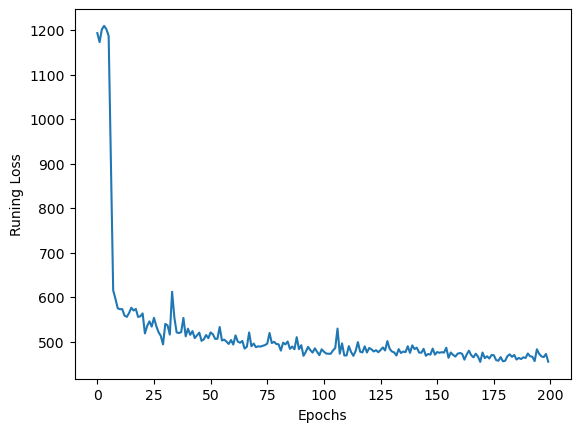

In [44]:
epoch_arr = np.arange(0, 200)
loss_arr = np.array(loss_arr)
plt.plot(epoch_arr, loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Runing Loss")
plt.show()

In [45]:
torch.save(final_model, 'model_200epoch.pt')

In [ ]:
final_model

In [55]:
saved_net = Net(b_values)
saved_net.load_state_dict(torch.load('model_200epoch.pt'))


<All keys matched successfully>

In [ ]:
saved_net.state_dict()

## Simulated Diffusion-Weighted MR Image

Create a simulated diffusion-weighted image. The image contains three regions with different Dp, Dt, and Fp values. 

In [46]:
b_arr1 = np.arange(281)
b_values_simulation = np.append(np.array([5,990,995,1000,5,990,995,1000]), b_arr1)

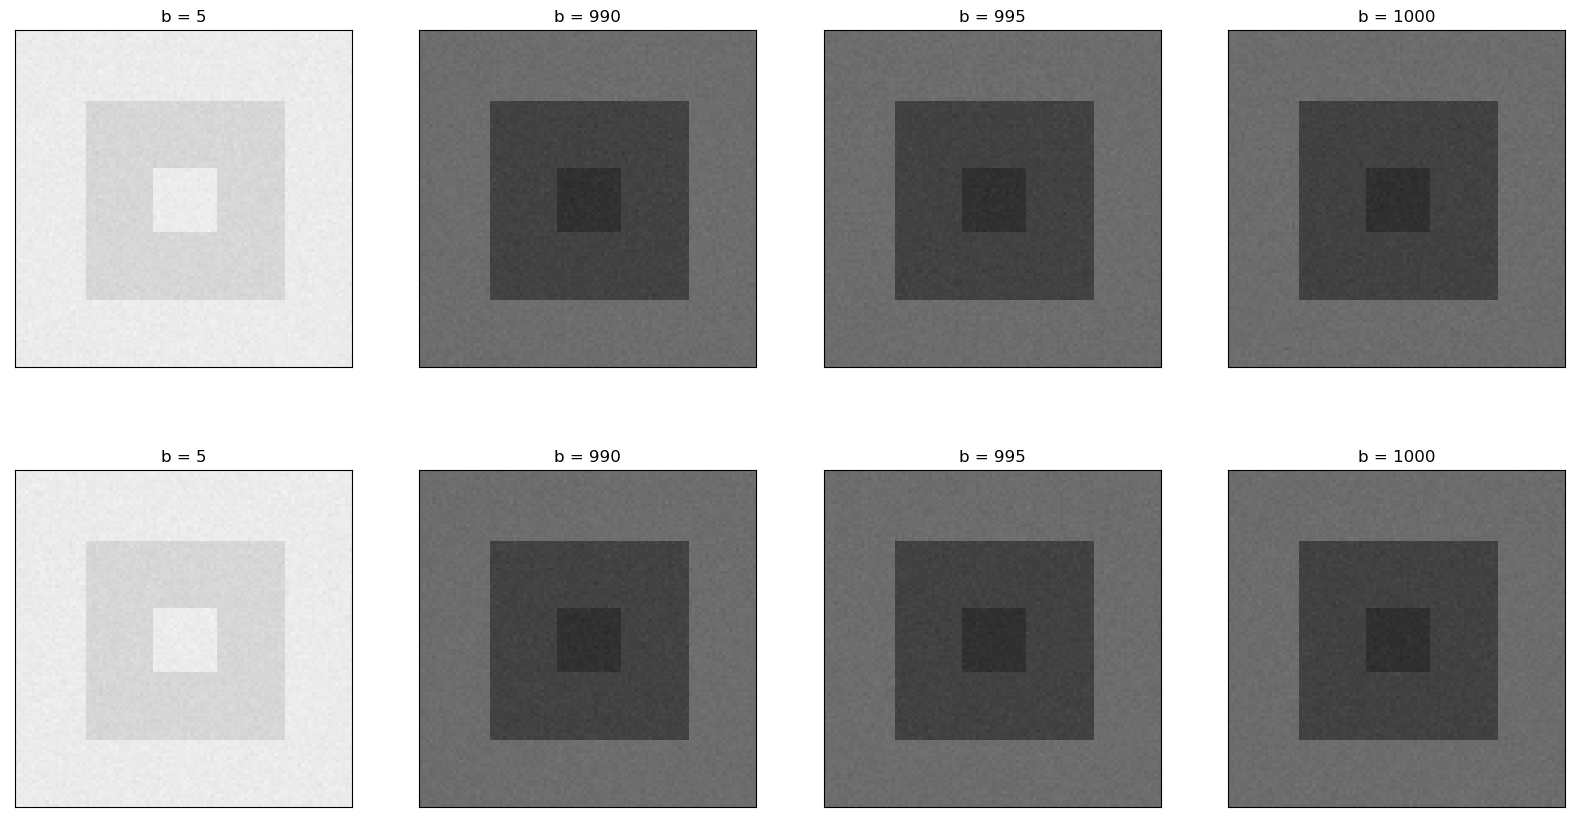

In [47]:
# define parameter values in the three regions
S0_region0, S0_region1, S0_region2 = 1500, 1400, 1600
Dp_region0, Dp_region1, Dp_region2 = 0.02, 0.04, 0.06
Dt_region0, Dt_region1, Dt_region2 = 0.0015, 0.0010, 0.0005
Fp_region0, Fp_region1, Fp_region2 = 0.1, 0.2, 0.3
# image size
sx, sy, sb = 100, 100, len(b_values_simulation)
# create image
dwi_image = np.zeros((sx, sy, sb))
Dp_truth = np.zeros((sx, sy))
Dt_truth = np.zeros((sx, sy))
Fp_truth = np.zeros((sx, sy))
# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (40 < i < 60) and (40 < j < 60):
            # region 0
            dwi_image[i, j, :] = S0_region0*ivim(b_values_simulation, Dp_region0, Dt_region0, Fp_region0)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region0, Dt_region0, Fp_region0
        elif (20 < i < 80) and (20 < j < 80):
            # region 1
            dwi_image[i, j, :] = S0_region1*ivim(b_values_simulation, Dp_region1, Dt_region1, Fp_region1)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region1, Dt_region1, Fp_region1
        else:
            # region 2
            dwi_image[i, j, :] = S0_region2*ivim(b_values_simulation, Dp_region2, Dt_region2, Fp_region2)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region2, Dt_region2, Fp_region2
# add some noise
dwi_image_real = dwi_image + np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image_imag = np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image = np.sqrt(dwi_image_real**2 + dwi_image_imag**2)
# plot simulated diffusion weighted image
fig, ax = plt.subplots(2, 4, figsize=(20,20))
b_id = 0
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray', clim=(0, 1600))
        ax[i, j].set_title('b = ' + str(b_values_simulation[b_id]))
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        b_id += 1
plt.subplots_adjust(hspace=-0.6)
plt.show()


## Inference

Estimate IVIM parameter values for the simulated image.

In [58]:
# net.load_state_dict(final_model)
# normalize signal
dwi_image_long = np.reshape(dwi_image, (sx*sy, sb))
S0 = np.expand_dims(dwi_image_long[:,0], axis=-1)
dwi_image_long = dwi_image_long[:,1:]/S0

net.eval()
with torch.no_grad():
    _, Dp, Dt, Fp = net(torch.from_numpy(dwi_image_long.astype(np.float32)))
    
Dp = Dp.numpy()
Dt = Dt.numpy()
Fp = Fp.numpy()

# make sure Dp is the larger value between Dp and Dt
if np.mean(Dp) < np.mean(Dt):
    Dp, Dt = Dt, Dp
    Fp = 1 - Fp

In [ ]:
Dp[50:100]

Plot parameter estimates and corresponding ground truths.

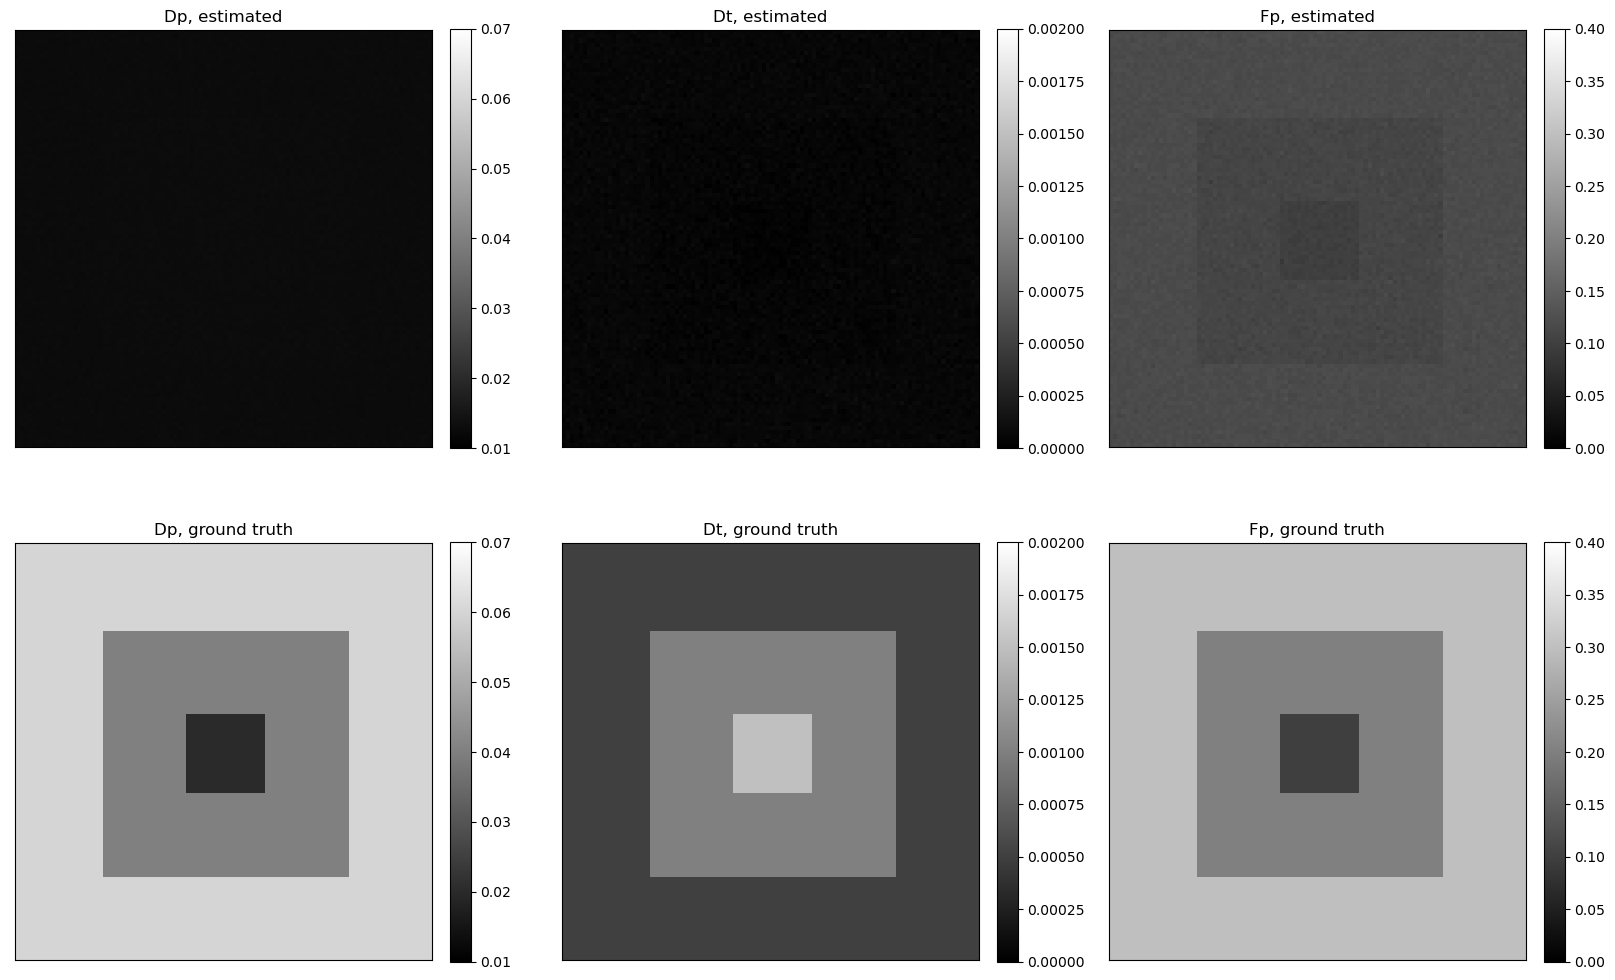

In [59]:
fig, ax = plt.subplots(2, 3, figsize=(20,20))

Dp_plot = ax[0,0].imshow(np.reshape(Dp, (sx, sy)), cmap='gray', clim=(0.01, 0.07))
ax[0,0].set_title('Dp, estimated')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(Dp_plot, ax=ax[0,0], fraction=0.046, pad=0.04)

Dp_t_plot = ax[1,0].imshow(Dp_truth, cmap='gray', clim=(0.01, 0.07))
ax[1,0].set_title('Dp, ground truth')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(Dp_t_plot, ax=ax[1,0], fraction=0.046, pad=0.04)

Dt_plot = ax[0,1].imshow(np.reshape(Dt, (sx, sy)), cmap='gray', clim=(0, 0.002))
ax[0,1].set_title('Dt, estimated')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(Dt_plot, ax=ax[0,1],fraction=0.046, pad=0.04)

Dt_t_plot = ax[1,1].imshow(Dt_truth, cmap='gray', clim=(0, 0.002))
ax[1,1].set_title('Dt, ground truth')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(Dt_t_plot, ax=ax[1,1], fraction=0.046, pad=0.04)

Fp_plot = ax[0,2].imshow(np.reshape(Fp, (sx, sy)), cmap='gray', clim=(0, 0.4))
ax[0,2].set_title('Fp, estimated')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
fig.colorbar(Fp_plot, ax=ax[0,2],fraction=0.046, pad=0.04)

Fp_t_plot = ax[1,2].imshow(Fp_truth, cmap='gray', clim=(0, 0.4))
ax[1,2].set_title('Fp, ground truth')
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
fig.colorbar(Fp_t_plot, ax=ax[1,2], fraction=0.046, pad=0.04)

plt.subplots_adjust(hspace=-0.5)
plt.show()